In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("Tweets.csv")

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
review_df = df[['text', 'airline_sentiment']]

print(review_df.shape)
review_df.head()

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


Neutral sentiment tweets are dropped as it is a binary classification problem

In [9]:
review_df = review_df[review_df['airline_sentiment'] != 'neutral']
print(review_df.shape)
review_df.head()

(11541, 2)


,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [10]:
review_df['airline_sentiment'].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

Categorical data is converted into numerical data using factorize() method. 

In [13]:
sentiment_label = review_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 1, ..., 0, 1, 1], dtype=int64),
 Index(['positive', 'negative'], dtype='object'))

0 = Positive Sentiment, 1 = Negative Sentiment

Text data needs to be converted into an array of vector embeddings for the ml model to understand. Word embeddings are a beautiful way of representing the relationship between the words in the text. Firstly, each of the unique words are assigned an unique number and then that word is replaced with the number assigned.

In [14]:
tweet = review_df.text.values

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [18]:
#words or sentences of a text is broken down into smaller parts called tokens using Tokenizer
#fit_on_texts() method creates an association between the words and the assigned numbers
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(tweet)

In [19]:
#words are replaced by their assigned numbers using texts_to_sequences() method
encoded_docs = tokenizer.texts_to_sequences(tweet)

In [23]:
vocab_size = len(tokenizer.word_index)+1

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#to make the text of equal length
padded_sequence = pad_sequences(encoded_docs, maxlen = 200)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

In [24]:
embedding_vector_length = 32
model = Sequential()

model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           423488    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
________________________________________________

In [25]:
history = model.fit(padded_sequence,sentiment_label[0], validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
289/289 [==============================] - 37s 121ms/step - loss: 0.3972 - accuracy: 0.8302 - val_loss: 0.2347 - val_accuracy: 0.9160
Epoch 2/5
289/289 [==============================] - 34s 119ms/step - loss: 0.2246 - accuracy: 0.9142 - val_loss: 0.1731 - val_accuracy: 0.9376
Epoch 3/5
289/289 [==============================] - 35s 121ms/step - loss: 0.1680 - accuracy: 0.9353 - val_loss: 0.1604 - val_accuracy: 0.9424
Epoch 4/5
289/289 [==============================] - 35s 120ms/step - loss: 0.1347 - accuracy: 0.9491 - val_loss: 0.1766 - val_accuracy: 0.9394
Epoch 5/5
289/289 [==============================] - 33s 115ms/step - loss: 0.1135 - accuracy: 0.9581 - val_loss: 0.1825 - val_accuracy: 0.9433


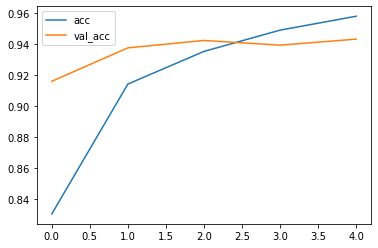

<Figure size 432x288 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


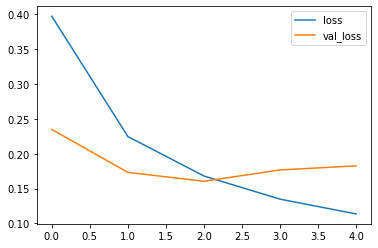

<Figure size 432x288 with 0 Axes>

In [29]:
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [31]:
def predict_sentiment(text):
    tw= tokenizer.texts_to_sequences([text])
    tw= pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted Label:", sentiment_label[1][prediction])

test_sentence1 = "I enjoyed my journey on this flight."
predict_sentiment(test_sentence1)
test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)    
    

Predicted Label: positive
Predicted Label: negative
